In [17]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from isotope_data_v3 import isotopes


In [21]:
#Covert text files into csv
#convert Absorption Cross Section Data
df_abs = pd.read_csv('Absorption_Cross_Section_Data.txt', delim_whitespace=True)
df_abs.to_csv('Absorption_Cross_Section_Data.csv', index=False)

#convert Capture Cross Section Data
df_capture = pd.read_csv('Capture_Cross_Section_Data.txt', delim_whitespace=True)
df_capture.to_csv('Capture_Cross_Section_Data.csv', index=False)

#convert n2n Cross Section Data
df_n2n = pd.read_csv('n2n_Cross_Section_Data.txt', delim_whitespace=True)
df_n2n.to_csv('n2n_Cross_Section_Data.csv', index=False)

#convert Neutron Energy Groups Data
# Read the file with multi-word headers using proper header rows and column names
df_neutron_energy = pd.read_csv(
    'Neutron_Energy_Groups.txt',
    delim_whitespace=True,
    header=None,
    skiprows=1,
    names=[
        'Energy Group',
        'Lower Boundary (eV)',
        'Upper Boundary (eV)'
    ]
)
df_neutron_energy.to_csv('Neutron_Energy_Groups.csv', index=False)


In [25]:
#Create a function to load cross-section data from CSV files
def load_cross_section_data(file_path):
    df = pd.read_csv(file_path)
    df.set_index(df.columns[0], inplace=True)  # Use the first column as index (energy groups)
    return df.to_dict(orient='list')  # Each isotope maps to a list of values over energy groups


# Load cross-section data
absorption_data = load_cross_section_data('Absorption_Cross_Section_Data.csv')
capture_data = load_cross_section_data('Capture_Cross_Section_Data.csv')
n2n_data = load_cross_section_data('n2n_Cross_Section_Data.csv')

#Build a dictionary for each reaction type
absorption_data = {isotope: data for isotope, data in absorption_data.items() if isotope in isotopes}
capture_data = {isotope: data for isotope, data in capture_data.items() if isotope
in isotopes}
n2n_data = {isotope: data for isotope, data in n2n_data.items() if isotope in isotopes}
# Create a dictionary to hold all cross-section data
cross_section_data = {
    'absorption': absorption_data,
    'capture': capture_data,
    'n2n': n2n_data
}

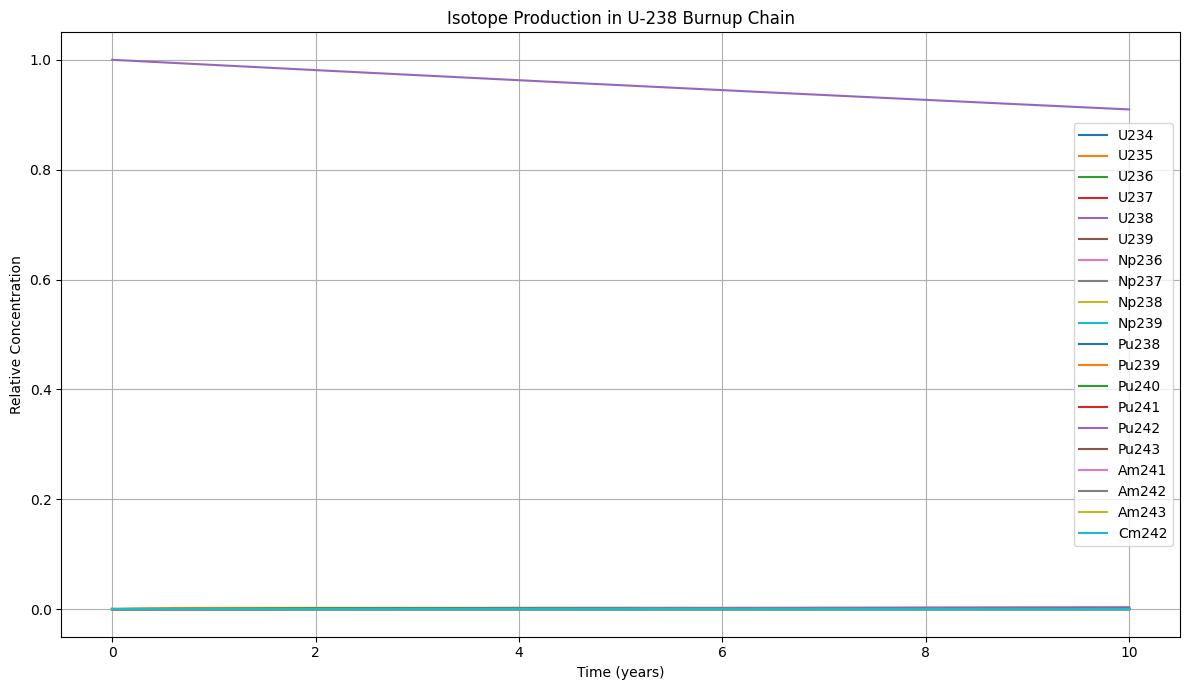

U234: 0.0000e+00
U235: 0.0000e+00
U236: 0.0000e+00
U237: 0.0000e+00
U238: 9.0967e-01
U239: 4.9962e-07
Np236: 0.0000e+00
Np237: 0.0000e+00
Np238: 0.0000e+00
Np239: 7.2151e-05
Pu238: 1.5262e-04
Pu239: 2.4223e-03
Pu240: 2.2942e-03
Pu241: 4.7629e-04
Pu242: 3.7004e-03
Pu243: 1.0367e-03
Am241: 1.2201e-05
Am242: 2.5245e-09
Am243: 1.8732e-04
Cm242: 1.4933e-05


In [16]:
phi = 1e14  # neutron flux [n/cm^2/s]
isotope_list = list(isotopes.keys())

# Map isotope to index for the ODE system
index_map = {iso: i for i, iso in enumerate(isotope_list)}
# Define the system of ODEs
def odes(t, y):
    dydt = np.zeros_like(y)
    for iso, props in isotopes.items():
        i = index_map[iso]
        # Loss terms (neutron reactions and decay)
        loss = (props['n_gamma'] + props['n_2n'] + props['n_fission']) * phi * y[i] + props['decay'] * y[i]
        prod = 0.0
        # Gain from parent reactions
        for parent, reaction in props['prod']:
            j = index_map[parent]
            if reaction == 'n_gamma':
                prod += isotopes[parent]['n_gamma'] * phi * y[j]
            elif reaction == 'n_2n':
                prod += isotopes[parent]['n_2n'] * phi * y[j]
            elif reaction == 'n_fission':
                prod += isotopes[parent]['n_fission'] * phi * y[j]
            elif reaction == 'decay':
                prod += isotopes[parent]['decay'] * y[j]
        dydt[i] = prod - loss
    return dydt


# Initial conditions (only U-238 present initially)
N0 = np.zeros(len(isotope_list))
# Ask user for starting isotope
start_isotope = input("Enter starting isotope (e.g., U238): ").strip()
if start_isotope not in index_map:
    raise ValueError(f"Isotope '{start_isotope}' not found in data.")

# Initial conditions
N0[index_map[start_isotope]] = 1.0

# Ask user how many years to simulate
years = float(input("Enter burnup duration in years (e.g., 10): "))
T_end = years * 365.25 * 24 * 3600  # convert years to seconds
t_eval = np.linspace(0, T_end, 1000)



# Solve the system
sol = solve_ivp(odes, [0, T_end], N0, t_eval=t_eval, method='BDF')

# Plot the results
plt.figure(figsize=(12, 7))
for i, iso in enumerate(isotope_list):
    plt.plot(sol.t / (365.25 * 24 * 3600), sol.y[i], label=iso)

plt.xlabel('Time (years)')
plt.ylabel('Relative Concentration')
plt.title('Isotope Production in U-238 Burnup Chain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the final concentrations
for i, iso in enumerate(isotope_list):
    print(f"{iso}: {sol.y[i][-1]:.4e}")
